In [ ]:
from IPython.display import clear_output
!pip install gdown==v4.6.3
!pip install ktrain==v0.39.0
clear_output()

In [ ]:
import os
import pandas as pd
import numpy as np
import ktrain as kt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import re
import nltk

In [ ]:
!gdown 1FJb76svNLLiuwNCuOjeLbjbXw81Fnt5y
df = pd.read_csv('2.1 - cgpt_labelled.csv', index_col=0)

Downloading...
From: https://drive.google.com/uc?id=1FJb76svNLLiuwNCuOjeLbjbXw81Fnt5y
To: /content/2.1 - cgpt_labelled.csv
100% 3.43M/3.43M [00:00<00:00, 21.6MB/s]


In [ ]:
len(df)

25419

In [ ]:
# cleaning from unwanted classes
emotions = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
df = df[df["emotion_chatgpt"].isin(emotions)]

In [ ]:
len(df)

25120

#### Clean up dialog in preparation for fine tuning

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# from https://dev.to/neurotech_africa/swahili-text-classification-using-transformers-4850
def clean_text(sentence):
    '''
        function to clean content column, make it ready for transformation and modeling
    '''
    sentence = sentence.lower()                #convert text to lower-case
    sentence = re.sub('â€˜','',sentence)    # remove the text â€˜ which appears to occur flequently
    sentence = re.sub('[‘’“”…,]', '', sentence) # remove punctuation
    sentence = re.sub('[()]', '', sentence)  #remove parentheses
    sentence = re.sub("[^a-zA-Z]"," ",sentence) #remove numbers and keep text/alphabet only
    sentence = nltk.word_tokenize(sentence)      # remove repeated characters (tanzaniaaaaaaaa to tanzania)

    return ' '.join(sentence)

In [ ]:
df['dialog'].head()

index
3     ...and harmony has been maintained in Equestri...
5     Oh, sorry, girls... I've got a lot of studying...
7         I know I've heard of the Elements of Harmony.
9                                Spike! Spi-ike! Spike?
10    There you are. Quick, find me that old copy of...
Name: dialog, dtype: object

In [ ]:
df['dialog'] = df['dialog'].apply(clean_text)
df['dialog'].head()

index
3     and harmony has been maintained in equestria f...
5     oh sorry girls i ve got a lot of studying to c...
7          i know i ve heard of the elements of harmony
9                                   spike spi ike spike
10    there you are quick find me that old copy of p...
Name: dialog, dtype: object

In [ ]:
df.head()

,title,writer,pony,dialog,emotion_chatgpt
index,,,,,
3,"Friendship is Magic, part 1",Lauren Faust,Twilight Sparkle,and harmony has been maintained in equestria f...,surprise
5,"Friendship is Magic, part 1",Lauren Faust,Twilight Sparkle,oh sorry girls i ve got a lot of studying to c...,neutral
7,"Friendship is Magic, part 1",Lauren Faust,Twilight Sparkle,i know i ve heard of the elements of harmony,neutral
9,"Friendship is Magic, part 1",Lauren Faust,Twilight Sparkle,spike spi ike spike,surprise
10,"Friendship is Magic, part 1",Lauren Faust,Twilight Sparkle,there you are quick find me that old copy of p...,surprise


In [ ]:
# Confirmed distribution of Emotions across train and test splits are more or less similar
100*df["emotion_chatgpt"].value_counts()/len(df)

joy         39.004777
neutral     19.454618
surprise    18.252389
fear         7.806529
anger        7.730892
sadness      5.370223
disgust      2.380573
Name: emotion_chatgpt, dtype: float64

In [ ]:
df["emotion_chatgpt"].value_counts()

joy         9798
neutral     4887
surprise    4585
fear        1961
anger       1942
sadness     1349
disgust      598
Name: emotion_chatgpt, dtype: int64

Confirming only the 6+1 emotions in the dataset

In [ ]:
class_names = df["emotion_chatgpt"].unique().tolist()
class_names = sorted(class_names) # better to use in confusion matrix later

In [ ]:
print(class_names)

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


Data preprocessing for BERT

In [ ]:
# sent_len = [len(x.split()) for x in X_train]

[]

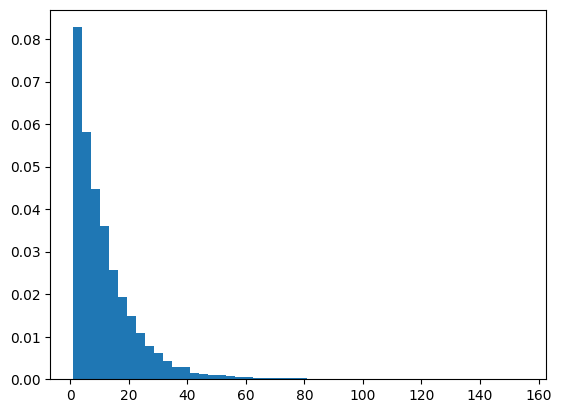

In [ ]:
# plt.hist(sent_len, density=True, bins=50)
# plt.plot()

In [ ]:
# sent_len.sort()
# cutoff_val = 40
# cutoff_idx = next(x[0] for x in enumerate(sent_len) if x[1] > cutoff_val)
# perc_sent_fewer_words_cutoff_val = cutoff_idx/len(sent_len)
# perc_sent_fewer_words_cutoff_val

0.9723043676069154

#### Data Preprocessing for Fine Tuning a Distilbert NN

In [ ]:
kt.text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [ ]:
trn, val, preproc = kt.text.texts_from_df(df, 'dialog', # name of column containing review text
                                          label_columns=['emotion_chatgpt'], maxlen=100, max_features=50000,
                                          preprocess_mode='distilbert', val_pct=0.2)

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
       anger  disgust  fear  joy  neutral  sadness  surprise
index                                                       
32085    0.0      0.0   0.0  1.0      0.0      0.0       0.0
9386     0.0      0.0   0.0  0.0      0.0      0.0       1.0
32030    0.0      0.0   0.0  1.0      0.0      0.0       0.0
36543    0.0      0.0   0.0  0.0      1.0      0.0       0.0
29902    0.0      0.0   0.0  0.0      0.0      1.0       0.0
['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']
       anger  disgust  fear  joy  neutral  sadness  surprise
index                                                       
8621     0.0      0.0   0.0  1.0      0.0      0.0       0.0
28304    0.0      0.0   0.0  0.0      0.0      0.0       1.0
22209    0.0      0.0   0.0  1.0      0.0      0.0       0.0
8843     0.0      0.0   0.0  1.0      0.0      0.0       0.0
2957     0.0      0.0   0.0  0.0      0.0      0.0       1.0
prepro

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 13
	95percentile : 35
	99percentile : 58


#### Build Model

In [ ]:
model = kt.text.text_classifier('distilbert', train_data=trn, preproc=preproc)

Is Multi-Label? False
maxlen is 100
done.


In [ ]:
learner = kt.get_learner(model, train_data=trn, val_data=val, batch_size=16) # default batch size = 32
# https://arxiv.org/abs/1609.04836 : Larger batch size leads to degradation in model ability to generalize

In [ ]:
# class_weights = dict(df_train["emotion_chatgpt"].value_counts()/len(df_train))
# class_weights = dict((encoding[key], value) for (key, value) in class_weights.items())

In [ ]:
learner.lr_find(max_epochs=2)

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
1256/1256 [==============================] - 231s 174ms/step - loss: 1.5445 - accuracy: 0.4328
Epoch 2/2
1256/1256 [==============================] - 219s 171ms/step - loss: 1.8175 - accuracy: 0.3600


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 8.20E-06
	Min numerical gradient (purple): 8.32E-07
	Min loss divided by 10 (omitted from plot): 5.56E-05


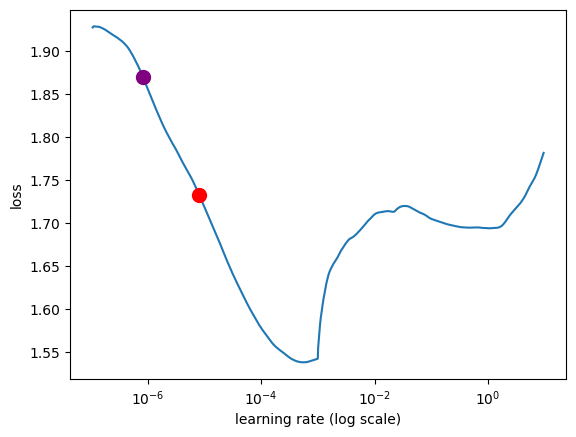

In [ ]:
learner.lr_plot(suggest=True)

In [ ]:
eps = 5
lr_opt = 5.56e-5 # for emotions_chatgpt

In [ ]:
history = learner.autofit(lr=lr_opt, epochs=eps, checkpoint_folder="checkpoints")



begin training using triangular learning rate policy with max lr of 5.56e-05...
Epoch 1/5
1256/1256 [==============================] - 260s 197ms/step - loss: 1.2051 - accuracy: 0.5618 - val_loss: 0.9814 - val_accuracy: 0.6361
Epoch 2/5
1256/1256 [==============================] - 242s 193ms/step - loss: 0.8094 - accuracy: 0.7149 - val_loss: 0.9714 - val_accuracy: 0.6385
Epoch 3/5
1256/1256 [==============================] - 243s 193ms/step - loss: 0.5599 - accuracy: 0.8110 - val_loss: 1.0490 - val_accuracy: 0.6447
Epoch 4/5
1256/1256 [==============================] - 243s 193ms/step - loss: 0.3792 - accuracy: 0.8753 - val_loss: 1.1833 - val_accuracy: 0.6361
Epoch 5/5
1256/1256 [==============================] - 239s 190ms/step - loss: 0.2666 - accuracy: 0.9110 - val_loss: 1.3144 - val_accuracy: 0.6355


<ipython-input-42-c6aa912d2c03>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(eps_, history.history["accuracy"], 'b', label='Training', color="blue")
<ipython-input-42-c6aa912d2c03>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(eps_, history.history["val_accuracy"], 'b', label='Validation', color="orange")
<ipython-input-42-c6aa912d2c03>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(eps_, history.history["loss"], 'b', label='Training', color="blue")
<ipython-input-42-c6aa912d2c03>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string

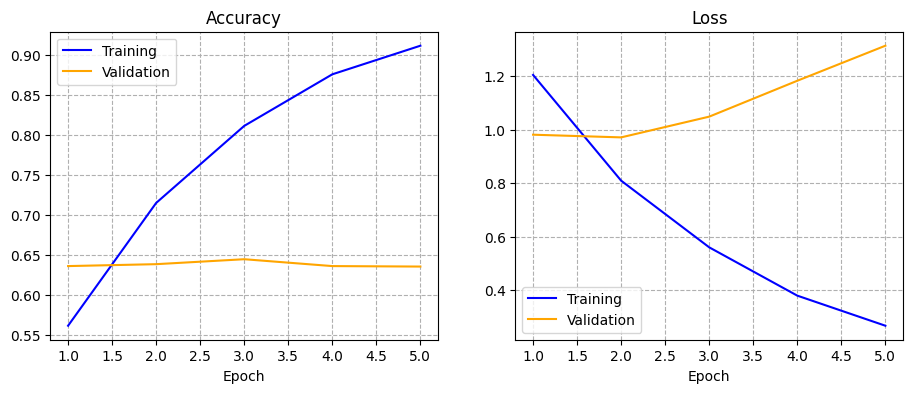

In [ ]:
eps_ = range(1, eps+1)

plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.grid(True, "both", linestyle="--")
plt.plot(eps_, history.history["accuracy"], 'b', label='Training', color="blue")
plt.plot(eps_, history.history["val_accuracy"], 'b', label='Validation', color="orange")
plt.title('Accuracy')
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
plt.grid(True, "both", linestyle="--")
plt.plot(eps_, history.history["loss"], 'b', label='Training', color="blue")
plt.plot(eps_, history.history["val_loss"], 'b', label='Validation', color="orange")
plt.title('Loss')
plt.xlabel("Epoch")
plt.legend()

#### Make Predictions on Total Data

In [ ]:
classifier = kt.get_predictor(model, preproc)

In [ ]:
y_pred = classifier.predict(df['dialog'].to_list())

In [ ]:
pd.Series(y_pred).value_counts()

joy         9900
neutral     4784
surprise    4390
fear        2054
anger       2030
sadness     1397
disgust      565
dtype: int64

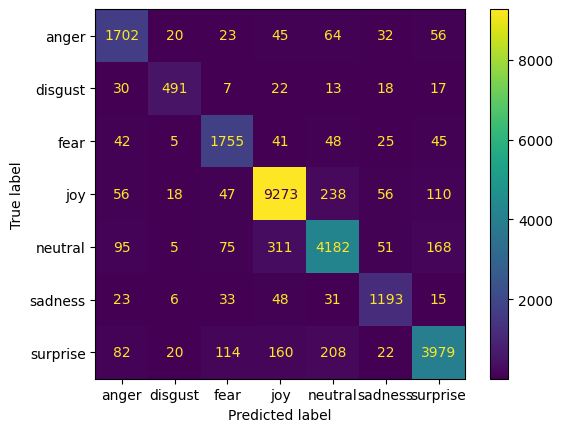

In [ ]:
cm = confusion_matrix(df['emotion_chatgpt'].to_list(), y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)
cm_display.plot()

In [ ]:
print(classification_report(df['emotion_chatgpt'].to_list(), y_pred))

              precision    recall  f1-score   support

       anger       0.84      0.88      0.86      1942
     disgust       0.87      0.82      0.84       598
        fear       0.85      0.89      0.87      1961
         joy       0.94      0.95      0.94      9798
     neutral       0.87      0.86      0.86      4887
     sadness       0.85      0.88      0.87      1349
    surprise       0.91      0.87      0.89      4585

    accuracy                           0.90     25120
   macro avg       0.88      0.88      0.88     25120
weighted avg       0.90      0.90      0.90     25120

